# Molecular Property Prediction
# 分子性质预测

- sigmoid函数是一种激活函数，它将输入值压缩到0到1之间。在深度学习中，sigmoid函数通常用于输出层，因为它可以将任意范围的输入值转换为0到1之间的概率。
- 
- 对于分子性质预测，我们将使用一个多层感知器（MLP）来预测分子的活性值。MLP由多个隐藏层组成，每个隐藏层都有多个神经元。输入层接收分子的SMILEs编码，输出层输出预测的活性值。
- 
- 为了训练模型，我们将使用带有权重的BCLWithLogitsLoss函数，它可以解决不平衡的类问题。
- 
- 我们将使用以下步骤：
- 1. 加载数据集
- 2. 准备数据
- 3. 定义模型
- 4. 训练模型
- 5. 评估模型
- 6. 预测分子活性值    
     

In [2]:
# Import libraries
import tqdm
import torch
import random
import torchvision

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.utils as vutils

from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
     

In [3]:
from pathlib import Path
import os

# 获取当前工作目录
HERE = Path(os.getcwd())
DATA = HERE / 'data'
if not DATA.exists():
    DATA.mkdir(parents=True, exist_ok=True)
print(DATA)


/Users/wangyang/Desktop/AI-drug-design/list/06_extension_lab/05_Molecular_Property_Prediction/data


In [4]:
# Load dataset
df = pd.read_csv(DATA / 'BBBP.csv')
df
     

,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...
...,...,...,...,...
2045,2049,licostinel,1,C1=C(Cl)C(=C(C2=C1NC(=O)C(N2)=O)[N+](=O)[O-])Cl
2046,2050,ademetionine(adenosyl-methionine),1,[C@H]3([N]2C1=C(C(=NC=N1)N)N=C2)[C@@H]([C@@H](...
2047,2051,mesocarb,1,[O+]1=N[N](C=C1[N-]C(NC2=CC=CC=C2)=O)C(CC3=CC=...
2048,2052,tofisoline,1,C1=C(OC)C(=CC2=C1C(=[N+](C(=C2CC)C)[NH-])C3=CC...


正如您在以下图中看到的，这些类是不平衡的，在训练模型中，我使用带有权重的BCLWithLogitsLoss函数解决了这个问题。

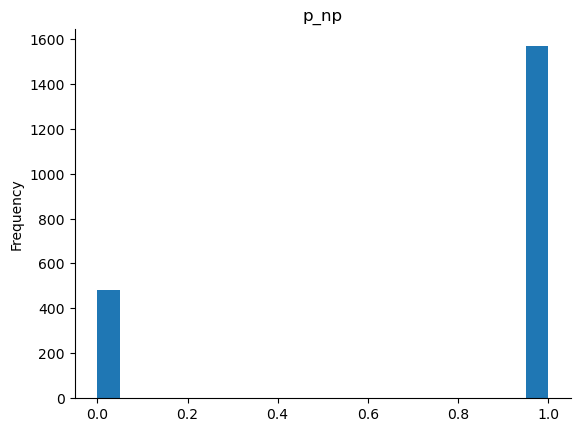

In [5]:
df['p_np'].plot(kind='hist', bins=20, title='p_np')
plt.gca().spines[['top', 'right',]].set_visible(False)
     

沿用权标化SMILEs公式，然后在包含权标化d SMILE的数据帧中增加新的一列。

In [6]:
def tokenize_smiles(smiles):

    tokens = []
    i = 0
    while i < len(smiles):
        # Check if the current and next characters form a two-character element
        current_char = smiles[i]
        next_char = smiles[i + 1] if i + 1 < len(smiles) else None
        if next_char is not None and current_char + next_char in ['Br', 'Cl', '@@']:
            tokens.append(current_char + next_char)
            i += 2
        else:
            tokens.append(current_char)
            i += 1
    return tokens

# apply the function on all rows of the dataframe
df['tokenized'] = df['smiles'].apply(tokenize_smiles)

后续函数将令牌化的SMILEs存储在一个集合中，以获得唯一的令牌。

In [8]:
unique_tokens = set()
for row in df['tokenized'].values :
    for token in row:
        unique_tokens.add(token)

unique_tokens_list = list(unique_tokens)
     

在下一个单元格中，我创建了一个令牌字典，将每个令牌映射到一个索引，以创建一个热编码。



In [9]:
token_dict = {}
for  idx, token in enumerate(unique_tokens_list):
    token_dict[token] = idx
print(token_dict)

{'=': 0, '2': 1, 'Br': 2, 'B': 3, 'P': 4, '3': 5, '4': 6, 'N': 7, 's': 8, 'I': 9, '5': 10, '[': 11, 'n': 12, '%': 13, '7': 14, '#': 15, '/': 16, '.': 17, 'S': 18, 'Cl': 19, 'o': 20, 'c': 21, '+': 22, '1': 23, '@': 24, '0': 25, '\\': 26, 'a': 27, ')': 28, 'F': 29, '(': 30, 'H': 31, '@@': 32, ']': 33, '9': 34, 'C': 35, '6': 36, 'O': 37, '8': 38, '-': 39}


现在我计算了令牌化SMILEs的长度，然后绘制长度图。

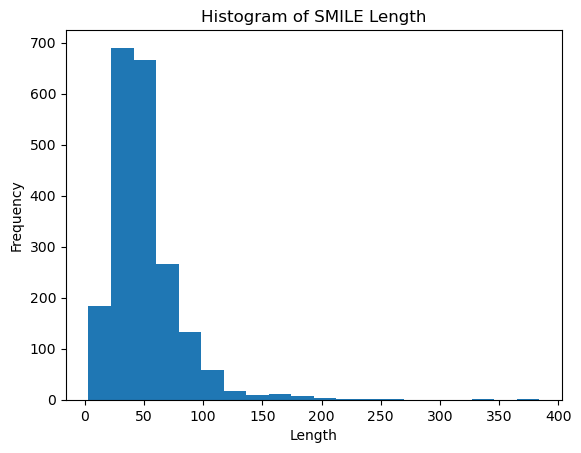

In [10]:
#在令牌化列的所有行上应用len函数
lengthes = df['tokenized'].apply(lambda x : len(x))

# plot histogram of lengthes
plt.hist(lengthes , bins=20)
plt.title('Histogram of SMILE Length')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()
     

In [11]:
# Get length statistics
max_length = np.max(lengthes)
min_length = np.min(lengthes)
avg_length = np.mean(lengthes)
print(f'Max length in the data set is {max_length} , Min length is {min_length},\n and the average length in tokenized SMILE is about {avg_length.round()}.')
     

Max length in the data set is 384 , Min length is 3,
 and the average length in tokenized SMILE is about 51.0.


在下面的单元格中，我计算每个令牌的频率，并将它们的数量存储在一个字典中，最后绘制令牌的频率。

In [12]:
# Calculate frequency of each token
token_frequency_dict = {}
for idx, token in enumerate(unique_tokens_list):
    token_frequency_dict[token] = 0

for smile in df['tokenized']:
    for token in smile:
        token_frequency_dict[token] +=1

print(token_frequency_dict)

{'=': 8034, '2': 3370, 'Br': 51, 'B': 1, 'P': 11, '3': 2553, '4': 1438, 'N': 3954, 's': 72, 'I': 6, '5': 454, '[': 3479, 'n': 515, '%': 24, '7': 56, '#': 53, '/': 184, '.': 163, 'S': 510, 'Cl': 618, 'o': 49, 'c': 6937, '+': 121, '1': 4128, '@': 1692, '0': 8, '\\': 203, 'a': 22, ')': 10491, 'F': 509, '(': 10491, 'H': 2392, '@@': 1251, ']': 3479, '9': 16, 'C': 29784, '6': 124, 'O': 6208, '8': 28, '-': 123}


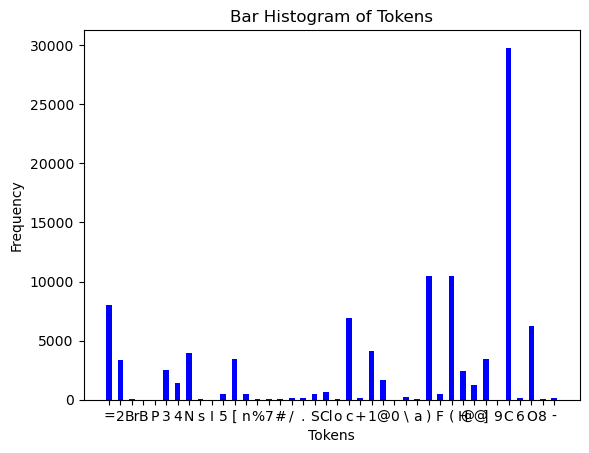

In [13]:
# Extract keys and values from the dictionary
tokens = list(token_frequency_dict.keys())
counts = list(token_frequency_dict.values())

# adjust the width
bar_width = 0.5

# Plotting the bar histogram
plt.bar(tokens, counts,width=bar_width, color='blue')

# Adding labels and title
plt.xlabel('Tokens')
plt.ylabel('Frequency')
plt.title('Bar Histogram of Tokens')
plt.show()

出现频率最高的是C (碳原子)，最少的是B (硼原子)。

In [14]:
# make multi hot vector for each SMILE formula to feed to MLP
list_of_multi_hots = []
for row in df['tokenized']:
    multi_hot = np.zeros(len(unique_tokens_list)) # 40
    for token in row:
        idx = token_dict[token]
        multi_hot[idx] = 1

    list_of_multi_hots.append(multi_hot)
     


In [15]:
df['Multi hot for MLP'] = list_of_multi_hots


In [18]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# X shape : 2050x40
X = np.array(df['Multi hot for MLP'].to_list())
y = np.array(df['p_np'].to_list())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create a simple fully connected neural network
class FCModel(nn.Module):
    def __init__(self, input_size):
        super(FCModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 10)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Define weights for positive and negative classes (pos_weight is around 0.3)
pos_weight = torch.tensor((y_train == 0).sum() / (y_train == 1).sum(), dtype=torch.float32)

# Initialize the model, loss function, and optimizer
fcModel = FCModel(input_size=X_train.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
optimizer = optim.Adam(fcModel.parameters(), lr=0.001)

# Train the model
num_epochs = 100
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):

    fcModel.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for batch_X, batch_y in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        outputs = fcModel(batch_X)
        loss = criterion(outputs, batch_y.view(-1, 1))
        loss.backward()
        optimizer.step()

        # Update statistics
        total_loss += loss.item()
        predicted_labels = (fcModel.sigmoid(outputs) >= 0.5).float()
        correct_predictions += torch.sum(predicted_labels.view(-1) == batch_y).item()
        total_samples += len(batch_y)

    # Calculate epoch-level statistics
    average_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples

    # Print epoch-level information
    print(f"\n Epoch {epoch + 1}/{num_epochs},  Train Loss: {average_loss:.4f}, Train Accuracy: {accuracy * 100:.2f}%")


# Evaluate the model on the test set
with torch.no_grad():
    fcModel.eval()
    test_outputs = fcModel(X_test_tensor)
    predicted_labels = (fcModel.sigmoid(test_outputs) >= 0.5).float()
    accuracy = torch.sum(predicted_labels.view(-1) == y_test_tensor).item() / len(y_test_tensor)

print(f"Accuracy on the test set: {accuracy * 100:.2f}%")

100%|██████████| 26/26 [00:00<00:00, 531.99it/s]



 Epoch 1/100,  Train Loss: 0.3380, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 643.23it/s]



 Epoch 2/100,  Train Loss: 0.3318, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 746.86it/s]



 Epoch 3/100,  Train Loss: 0.3280, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 779.00it/s]



 Epoch 4/100,  Train Loss: 0.3251, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 667.28it/s]



 Epoch 5/100,  Train Loss: 0.3221, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 692.13it/s]



 Epoch 6/100,  Train Loss: 0.3203, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 639.84it/s]



 Epoch 7/100,  Train Loss: 0.3180, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 625.63it/s]



 Epoch 8/100,  Train Loss: 0.3141, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 639.81it/s]



 Epoch 9/100,  Train Loss: 0.3120, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 626.11it/s]



 Epoch 10/100,  Train Loss: 0.3098, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 632.88it/s]



 Epoch 11/100,  Train Loss: 0.3062, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 591.02it/s]



 Epoch 12/100,  Train Loss: 0.3046, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 599.96it/s]



 Epoch 13/100,  Train Loss: 0.3016, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 597.29it/s]



 Epoch 14/100,  Train Loss: 0.3012, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 650.16it/s]



 Epoch 15/100,  Train Loss: 0.2995, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 649.06it/s]



 Epoch 16/100,  Train Loss: 0.2969, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 549.08it/s]



 Epoch 17/100,  Train Loss: 0.2958, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 652.97it/s]



 Epoch 18/100,  Train Loss: 0.2935, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 659.26it/s]



 Epoch 19/100,  Train Loss: 0.2936, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 663.15it/s]



 Epoch 20/100,  Train Loss: 0.2919, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 610.30it/s]



 Epoch 21/100,  Train Loss: 0.2905, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 657.33it/s]



 Epoch 22/100,  Train Loss: 0.2909, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 670.43it/s]



 Epoch 23/100,  Train Loss: 0.2896, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 628.10it/s]



 Epoch 24/100,  Train Loss: 0.2886, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 656.73it/s]



 Epoch 25/100,  Train Loss: 0.2876, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 674.73it/s]



 Epoch 26/100,  Train Loss: 0.2886, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 620.88it/s]



 Epoch 27/100,  Train Loss: 0.2870, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 662.52it/s]



 Epoch 28/100,  Train Loss: 0.2865, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 688.72it/s]



 Epoch 29/100,  Train Loss: 0.2875, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 691.54it/s]



 Epoch 30/100,  Train Loss: 0.2851, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 651.07it/s]



 Epoch 31/100,  Train Loss: 0.2857, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 684.81it/s]



 Epoch 32/100,  Train Loss: 0.2845, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 785.29it/s]



 Epoch 33/100,  Train Loss: 0.2834, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 678.02it/s]



 Epoch 34/100,  Train Loss: 0.2837, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 666.24it/s]



 Epoch 35/100,  Train Loss: 0.2835, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 698.25it/s]



 Epoch 36/100,  Train Loss: 0.2826, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 699.36it/s]



 Epoch 37/100,  Train Loss: 0.2827, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 765.09it/s]



 Epoch 38/100,  Train Loss: 0.2817, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 676.98it/s]



 Epoch 39/100,  Train Loss: 0.2823, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 693.19it/s]



 Epoch 40/100,  Train Loss: 0.2827, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 693.61it/s]



 Epoch 41/100,  Train Loss: 0.2828, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 730.97it/s]



 Epoch 42/100,  Train Loss: 0.2815, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 699.24it/s]



 Epoch 43/100,  Train Loss: 0.2808, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 787.09it/s]



 Epoch 44/100,  Train Loss: 0.2806, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 621.10it/s]



 Epoch 45/100,  Train Loss: 0.2795, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 589.56it/s]



 Epoch 46/100,  Train Loss: 0.2801, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 598.31it/s]



 Epoch 47/100,  Train Loss: 0.2801, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 513.10it/s]



 Epoch 48/100,  Train Loss: 0.2804, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 568.87it/s]



 Epoch 49/100,  Train Loss: 0.2804, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 581.86it/s]



 Epoch 50/100,  Train Loss: 0.2807, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 691.93it/s]



 Epoch 51/100,  Train Loss: 0.2794, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 794.28it/s]



 Epoch 52/100,  Train Loss: 0.2800, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 791.43it/s]



 Epoch 53/100,  Train Loss: 0.2797, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 782.92it/s]



 Epoch 54/100,  Train Loss: 0.2800, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 719.04it/s]



 Epoch 55/100,  Train Loss: 0.2795, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 787.97it/s]



 Epoch 56/100,  Train Loss: 0.2798, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 830.59it/s]



 Epoch 57/100,  Train Loss: 0.2792, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 702.26it/s]



 Epoch 58/100,  Train Loss: 0.2785, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 666.68it/s]



 Epoch 59/100,  Train Loss: 0.2781, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 698.66it/s]



 Epoch 60/100,  Train Loss: 0.2791, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 684.23it/s]



 Epoch 61/100,  Train Loss: 0.2789, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 687.05it/s]



 Epoch 62/100,  Train Loss: 0.2791, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 674.60it/s]



 Epoch 63/100,  Train Loss: 0.2800, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 718.41it/s]



 Epoch 64/100,  Train Loss: 0.2790, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 692.43it/s]



 Epoch 65/100,  Train Loss: 0.2772, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 709.96it/s]



 Epoch 66/100,  Train Loss: 0.2782, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 729.91it/s]



 Epoch 67/100,  Train Loss: 0.2774, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 837.73it/s]



 Epoch 68/100,  Train Loss: 0.2784, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 658.49it/s]



 Epoch 69/100,  Train Loss: 0.2774, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 704.97it/s]



 Epoch 70/100,  Train Loss: 0.2772, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 696.10it/s]



 Epoch 71/100,  Train Loss: 0.2781, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 693.74it/s]



 Epoch 72/100,  Train Loss: 0.2769, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 829.77it/s]



 Epoch 73/100,  Train Loss: 0.2772, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 734.55it/s]



 Epoch 74/100,  Train Loss: 0.2773, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 710.44it/s]



 Epoch 75/100,  Train Loss: 0.2768, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 721.02it/s]



 Epoch 76/100,  Train Loss: 0.2766, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 547.02it/s]



 Epoch 77/100,  Train Loss: 0.2770, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 637.21it/s]



 Epoch 78/100,  Train Loss: 0.2766, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 699.87it/s]



 Epoch 79/100,  Train Loss: 0.2779, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 717.42it/s]



 Epoch 80/100,  Train Loss: 0.2767, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 646.97it/s]



 Epoch 81/100,  Train Loss: 0.2768, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 680.36it/s]



 Epoch 82/100,  Train Loss: 0.2765, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 751.79it/s]



 Epoch 83/100,  Train Loss: 0.2764, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 682.79it/s]



 Epoch 84/100,  Train Loss: 0.2760, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 708.64it/s]



 Epoch 85/100,  Train Loss: 0.2770, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 764.64it/s]



 Epoch 86/100,  Train Loss: 0.2760, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 735.61it/s]



 Epoch 87/100,  Train Loss: 0.2762, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 712.52it/s]



 Epoch 88/100,  Train Loss: 0.2768, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 745.18it/s]



 Epoch 89/100,  Train Loss: 0.2762, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 834.57it/s]



 Epoch 90/100,  Train Loss: 0.2767, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 803.46it/s]



 Epoch 91/100,  Train Loss: 0.2765, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 704.05it/s]



 Epoch 92/100,  Train Loss: 0.2762, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 706.94it/s]



 Epoch 93/100,  Train Loss: 0.2768, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 720.94it/s]



 Epoch 94/100,  Train Loss: 0.2752, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 685.29it/s]



 Epoch 95/100,  Train Loss: 0.2750, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 739.07it/s]



 Epoch 96/100,  Train Loss: 0.2752, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 843.58it/s]



 Epoch 97/100,  Train Loss: 0.2763, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 881.63it/s]



 Epoch 98/100,  Train Loss: 0.2761, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 791.83it/s]



 Epoch 99/100,  Train Loss: 0.2763, Train Accuracy: 76.34%


100%|██████████| 26/26 [00:00<00:00, 739.98it/s]


 Epoch 100/100,  Train Loss: 0.2756, Train Accuracy: 76.34%
Accuracy on the test set: 76.83%


# 下面是基于GPU的版本

In [19]:
# find the longest length
lengthes = df['tokenized'].apply(lambda x : len(x))
MAX_LENGTH = np.max(lengthes.to_list())

# create 40D one hot vector for each token (Each SMILE sequence will be a 384x40 tensor)
list_of_data_LSTM = []

for smile in df['tokenized']:
    two_dim_array = np.zeros((MAX_LENGTH, len(unique_tokens_list))) #384X40
    for token_index, token in enumerate(smile):
        idx = token_dict[token]
        two_dim_array[383-token_index][idx] = 1

    list_of_data_LSTM.append(two_dim_array)

In [20]:
np.array(list_of_data_LSTM).shape


(2050, 384, 40)

In [ ]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# X_LSTM shape : (2050, 384, 40)
X_LSTM = np.array(list_of_data_LSTM)
y = np.array(df['p_np'].to_list())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_LSTM, y, test_size=0.1, random_state=40)

# Define weights for positive and negative classes (pos_weight is around 0.3)
pos_weight = torch.tensor((y_train == 0).sum() / (y_train == 1).sum(), dtype=torch.float32)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Define the LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 16)
        self.relu1 = nn.ReLU()
        self.fc3 = nn.Linear(16, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        lstm_out, _ = self.lstm(x)

        # Take the output from the last time step
        lstm_out = lstm_out[:, -1, :]
        x = self.fc1(lstm_out)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu1(x)
        x = self.fc3(x)
        # x = self.sigmoid(x)
        return x

# Initialize the LSTM model input_size = 40
input_size = X_train_tensor.shape[2]

# The number of features in the hidden state
hidden_size = 128

# Two stacked LSTM
num_layers = 2

# Binary classification
output_size = 1
lstm_model = LSTMClassifier(input_size, hidden_size, num_layers, output_size).to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
optimizer = optim.Adam(lstm_model.parameters(), lr=0.0001)

# Train the LSTM model
num_epochs = 50
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    lstm_model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for batch_X, batch_y in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        outputs = lstm_model(batch_X)
        loss = criterion(outputs, batch_y.view(-1, 1))
        loss.backward()
        optimizer.step()

        # Update statistics
        total_loss += loss.item()
        predicted_labels = (lstm_model.sigmoid(outputs) >= 0.5).float()
        correct_predictions += torch.sum(predicted_labels.view(-1) == batch_y).item()
        total_samples += len(batch_y)


    # Calculate epoch-level statistics
    accuracy = correct_predictions / total_samples
    average_loss = total_loss / len(train_loader)

    # Print epoch-level information
    print(f"Epoch {epoch + 1}/{num_epochs},  Train Loss: {average_loss:.4f}, Train Accuracy: {accuracy * 100:.2f}% \n")



# Evaluate the LSTM model on the test set
with torch.no_grad():
    lstm_model.eval()
    test_outputs = lstm_model(X_test_tensor)
    predicted_labels = (lstm_model.sigmoid(test_outputs) >= 0.5).float()
    accuracy = torch.sum(predicted_labels.view(-1) == y_test_tensor).item() / len(y_test_tensor)

print(f"Accuracy on the test set: {accuracy * 100:.2f}%")

100%|██████████| 58/58 [01:52<00:00,  1.94s/it]


Epoch 1/50,  Train Loss: 0.3368, Train Accuracy: 24.23% 


100%|██████████| 58/58 [03:20<00:00,  3.45s/it]


Epoch 2/50,  Train Loss: 0.3358, Train Accuracy: 24.23% 


 29%|██▉       | 17/58 [00:53<02:40,  3.91s/it]

In [ ]:
# Define the BiLSTM model
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTMClassifier, self).__init__()
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)

        # Multiply by 2 for bidirectional
        self.fc1 = nn.Linear(hidden_size * 2, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 16)
        self.relu1 = nn.ReLU()
        self.fc3 = nn.Linear(16, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        bilstm_out, _ = self.bilstm(x)
        # Concatenate the outputs from the last time step in both directions
        bilstm_out = torch.cat((bilstm_out[:, -1, :hidden_size], bilstm_out[:, 0, hidden_size:]), dim=1)
        x = self.fc1(bilstm_out)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu1(x)
        x = self.fc3(x)
        # x = self.sigmoid(x)
        return x


# Initialize the LSTM model input_size = 40
input_size = X_train_tensor.shape[2]

# Reduced hidden size for bidirectional
hidden_size = 64
num_layers = 2
output_size = 1
bilstm_model = BiLSTMClassifier(input_size, hidden_size, num_layers, output_size).to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
optimizer = optim.Adam(bilstm_model.parameters(), lr=0.001)

# Train the BiLSTM model
num_epochs = 50
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    bilstm_model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for batch_X, batch_y in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        outputs = bilstm_model(batch_X)
        loss = criterion(outputs, batch_y.view(-1, 1))
        loss.backward()
        optimizer.step()

        # Update statistics
        total_loss += loss.item()
        predicted_labels = (bilstm_model.sigmoid(outputs) >= 0.5).float()
        correct_predictions += torch.sum(predicted_labels.view(-1) == batch_y).item()
        total_samples += len(batch_y)


    # Calculate epoch-level statistics
    accuracy = correct_predictions / total_samples
    average_loss = total_loss / len(train_loader)

    # Print epoch-level information
    print(f"Epoch {epoch + 1}/{num_epochs},  Train Loss: {average_loss:.4f}, Train Accuracy: {accuracy * 100:.2f}% \n")



# Evaluate the BiLSTM model on the test set
with torch.no_grad():
    bilstm_model.eval()
    test_outputs = bilstm_model(X_test_tensor)
    predicted_labels = (bilstm_model.sigmoid(test_outputs) >= 0.5).float()
    accuracy = torch.sum(predicted_labels.view(-1) == y_test_tensor).item() / len(y_test_tensor)

print(f"Accuracy on the test set: {accuracy * 100:.2f}%")


# LSTM交叉验证

In [ ]:
# Initialize the LSTM model input_size = 40
input_size = X_train_tensor.shape[2]

# The number of features in the hidden state
hidden_size = 128

# Two stacked LSTM
num_layers = 2

# Binary classification
output_size = 1
lstm_model = LSTMClassifier(input_size, hidden_size, num_layers, output_size).to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)


# k-fold cross-validation
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# create array to store accs
all_accuracies = []

X_tensor = torch.tensor(X_LSTM, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Perform k-fold cross-validation
for fold, (train_index, test_index) in enumerate(skf.split(X_tensor, y_tensor)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Split the data into training and testing sets for this fold
    X_train_fold, X_test_fold = X_tensor[train_index], X_tensor[test_index]
    y_train_fold, y_test_fold = y_tensor[train_index], y_tensor[test_index]

    # Create DataLoader for training set
    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Train the LSTM model
    num_epochs = 50
    for epoch in range(num_epochs):
        lstm_model.train()
        total_loss = 0.0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = lstm_model(batch_X)
            loss = criterion(outputs, batch_y.view(-1, 1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        average_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}")

    # Evaluate the LSTM model on the test set for this fold
    with torch.no_grad():
        lstm_model.eval()
        X_test_fold, y_test_fold = X_test_fold.to(device), y_test_fold.to(device)
        test_outputs = bilstm_model(X_test_fold)
        predicted_labels = (lstm_model.sigmoid(test_outputs) >= 0.5).float()
        accuracy_fold = accuracy_score(y_test_fold.cpu().numpy(), predicted_labels.cpu().numpy())
        all_accuracies.append(accuracy_fold)

        print(f"Test Accuracy on Fold {fold + 1}: {accuracy_fold * 100:.2f}%")

# Print overall performance metrics
average_accuracy = np.mean(all_accuracies)
print(f"\nAverage Accuracy: {average_accuracy * 100:.2f}%")

In [ ]:
np.std([88.54,91.46,93.17,88.29,91.71])


# BiLSTM交叉验证

In [ ]:
# Initialize the BiLSTM model input_size = 40
input_size = X_train_tensor.shape[2]

# Reduced hidden size for bidirectional
hidden_size = 64
num_layers = 2
output_size = 1

bilstm_model = BiLSTMClassifier(input_size, hidden_size, num_layers, output_size).to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
optimizer = optim.Adam(bilstm_model.parameters(), lr=0.001)

# k-fold cross-validation
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=40)

# create arrays to store accs
all_accuracies = []

X_tensor = torch.tensor(X_LSTM, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Perform k-fold cross-validation
for fold, (train_index, test_index) in enumerate(skf.split(X_tensor, y_tensor)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Split the data into training and testing sets for this fold
    X_train_fold, X_test_fold = X_tensor[train_index], X_tensor[test_index]
    y_train_fold, y_test_fold = y_tensor[train_index], y_tensor[test_index]

    # Create DataLoader for training set
    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Train the BiLSTM model
    num_epochs = 50
    for epoch in range(num_epochs):
        bilstm_model.train()
        total_loss = 0.0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = bilstm_model(batch_X)
            loss = criterion(outputs, batch_y.view(-1, 1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        average_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}")

    # Evaluate the BiLSTM model on the test set for this fold
    with torch.no_grad():
        bilstm_model.eval()
        X_test_fold, y_test_fold = X_test_fold.to(device), y_test_fold.to(device)
        test_outputs = bilstm_model(X_test_fold)
        predicted_labels = (bilstm_model.sigmoid(test_outputs) >= 0.5).float()
        accuracy_fold = accuracy_score(y_test_fold.cpu().numpy(), predicted_labels.cpu().numpy())
        all_accuracies.append(accuracy_fold)

        print(f"Test Accuracy on Fold {fold + 1}: {accuracy_fold * 100:.2f}%")

# Print overall performance metrics
average_accuracy = np.mean(all_accuracies)
print(f"\nAverage Accuracy: {average_accuracy * 100:.2f}%")

In [ ]:
np.std([87.32,90.49,89.51,96.83,95.37])


## 结论

基线模型（FC模型）的准确率为76.83%，顶级列车的准确率为76.34%。

LSTM模型的平均准确率为90.63%（-+ 1.90%），最高准确率为93.17%。

BiLSTM模型的平均精度为91.90%（-+3.60%），最高精度为96.83%。

BiLSTM和LSTM

BiLSTM在正向和向后方向上处理输入序列。这允许模型从序列的开头和结尾捕获上下文信息。对于SMILES公式来说，代币的顺序在确定分子结构方面至关重要，拥有来自双向的信息可能是有益的。

在LSTM中，在处理令牌时，未来的信息不可用，可能会导致信息丢失。相比之下，BiLSTM通过双向处理令牌来解决这个问题，确保每个令牌都可以访问过去和未来令牌的信息。

一言以蔽之，BiLSTM的双向性质使其能够学习更丰富的特征表示。